In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
from os import listdir

In [ ]:
EPOCHS = 20
INIT_LR = 0.001
BS = 8
# BS = 32

# opt = SGD(lr=INIT_LR, decay=0.0001)
# opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
opt = Adam(learning_rate=INIT_LR)

mc = ModelCheckpoint(r'/content/Forest Fire CNN/ffs_cnn.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# mc = ModelCheckpoint(r'/G:\My Drive\Ikbal\Dataset\Training/ffs_cnn.h5', monitor='val_accuracy', verbose=1)

default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/MyDrive/mydatasett/training'
width=256
height=256
depth=3

# Load Dataset

## Function to convert images to array

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []
# try:
print("[INFO] Loading images ...")
root_dir = listdir(directory_root)
# root_dir = directory_root

for directory in root_dir :
    # remove .DS_Store from list
    if directory == ".DS_Store" :
        root_dir.remove(directory)

for plant_folder in root_dir :
    plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

    for disease_folder in plant_disease_folder_list :
        # remove .DS_Store from list
        if disease_folder == ".DS_Store" :
            plant_disease_folder_list.remove(disease_folder)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

        for single_plant_disease_image in plant_disease_image_list :
            if single_plant_disease_image == ".DS_Store" :
                plant_disease_image_list.remove(single_plant_disease_image)

        for image in plant_disease_image_list:
            image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or image_directory.endswith(".jpeg") == True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)
print("[INFO] Image loading completed")
# except Exception as e:
#     print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing gunting ...
[INFO] Processing tang ...
[INFO] Image loading completed


# Preprocessing

## Get Size of Processed Image

In [ ]:
image_size = len(image_list)
image_size

287

## Transforrm Image Labels using Scikit Learn's Label Binarizer

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open(r'forest_fire_smoke_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['gunting' 'tang']


In [ ]:
# np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
image_list = np.array(image_list, dtype=np.float16) / 225.0

## Splitting Data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(image_list, image_labels, test_size=0.1, random_state=42)

In [ ]:
import gc
gc.collect()

7685

In [ ]:
del(image_list)
del(image_labels)

## Image Generator

In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
gc.collect()

0

# Create Model & Training

## Create function to Create Model based on Model Arch

In [ ]:
def fit_model(n_nodes, idx):

    ###################
    #define model arch

    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1

    ### 1
    model.add(Conv2D(n_nodes[idx][0], (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    # model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    # model.add(Dropout(0.25))

    ### 2
    model.add(Conv2D(n_nodes[idx][1], (3, 3), padding="same"))
    model.add(Activation("relu"))
    # model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))

    ### 3
    model.add(Conv2D(n_nodes[idx][2], (3, 3), padding="same"))
    model.add(Activation("relu"))
    # model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))

#     ## 4
#     model.add(Conv2D(n_nodes[idx][3], (3, 3), padding="same"))
#     model.add(Activation("relu"))
#     model.add(BatchNormalization(axis=chanDim))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
# #     model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(n_nodes[idx][3]))
    model.add(Activation("relu"))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    # model.add(Activation("softmax"))
    model.add(Activation("sigmoid"))

    ###################
    #compile model & fit

    # model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
    # model.compile(loss="binary_crossentropy", metrics=["accuracy"])
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

    print(f'Training {idx+1}st Arch!')
    history = model.fit(
        aug.flow(x_train, y_train, batch_size=BS),
        validation_data=(x_test, y_test),
        steps_per_epoch=len(x_train) // BS,
        epochs=EPOCHS, verbose=1, callbacks=[mc]
        # epochs=EPOCHS, verbose=1
        )

    ###################
    #plot learning curves

    acc = history.history['accuracy']
    epoch = range(1, len(acc) + 1)

    plt.subplot(len(n_nodes),2,(idx+1)*2-1)
    plt.plot(epoch, history.history['accuracy'], label='train acc')
    plt.plot(epoch, history.history['val_accuracy'], label='val acc')
    plt.title(f'Accuracy, node {n_nodes[idx]}')
    plt.legend()

    plt.subplot(len(n_nodes),2,(idx+1)*2)
    plt.plot(epoch, history.history['loss'], label='train loss')
    plt.plot(epoch, history.history['val_loss'], label='val loss')
    plt.title(f'Loss, node {n_nodes[idx]}')
    plt.legend()


In [ ]:
import gc

In [ ]:
gc.collect()

0

## Launch Train Function

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training 1st Arch!


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5931 - loss: 0.0000e+00
Epoch 1: val_accuracy improved from -inf to 0.62069, saving model to /content/Forest Fire CNN/ffs_cnn.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 300ms/step - accuracy: 0.5922 - loss: 0.0000e+00 - val_accuracy: 0.6207 - val_loss: 0.0000e+00
Epoch 2/20
 1/32 ━━━━━━━━━━━━━━━━━━━━ 1:31 3s/step - accuracy: 0.5000 - loss: 0.0000e+00
Epoch 2: val_accuracy did not improve from 0.62069
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5000 - loss: 0.0000e+00 - val_accuracy: 0.6207 - val_loss: 0.0000e+00
Epoch 3/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5550 - loss: 0.0000e+00
Epoch 3: val_accuracy did not improve from 0.62069
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.5551 - loss: 0.0000e+00 - val_accuracy: 0.6207 - val_loss: 0.0000e+00
Epoch 4/20
 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6250 - loss: 0.0000e+00
Epoch 4: val_accuracy did not improve from 0.62069
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6250 - loss: 0.0000e+00 - val_accuracy: 0.6207 - val_loss: 0.0000e+00
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5835 - loss: 0.0000e+00
Epoch 5: val_accuracy did not improve from 0.62069
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.5827 - loss: 0.0000e+00 - val_accuracy: 0.6207 - val_loss: 0.0000e+00
Epoch 6/20
 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5000 - loss: 0.0000e+00
Epoch 6: val_accuracy did not improve from 0.62069
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5000 - loss: 0.0000e+00

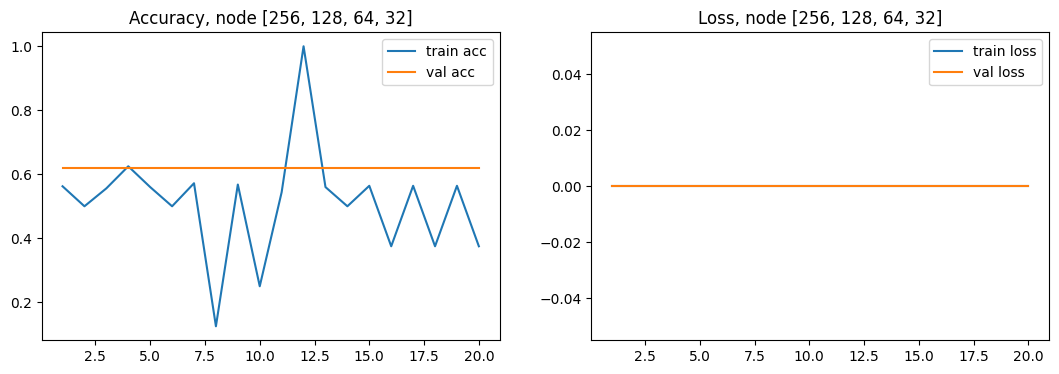

In [ ]:
n_nodes = [
    [256, 128, 64, 32]
]

plt.figure(figsize=(13, 4*len(n_nodes)))
for x in range(len(n_nodes)):

    fit_model(n_nodes, x)
    print(f'{x+1}st Arch finished !')

# show learning curves
plt.show()

In [ ]:
from keras.models import load_model

In [ ]:
fs_7030 = load_model('/content/Forest Fire CNN/ffs_cnn.h5')

In [ ]:
loss, acc = fs_7030.evaluate(x_train, y_train)

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.5677 - loss: 0.0000e+00


In [ ]:
loss, acc = fs_7030.evaluate(x_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6207 - loss: 0.0000e+00


## Load  & Testing

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
cs_adam_10 = load_model('/content/Forest Fire CNN/ffs_cnn.h5')

In [ ]:
gmbr1 = cv2.imread('/content/drive/MyDrive/mydatasett/training/training/tang/IMG20250725193214.jpg')

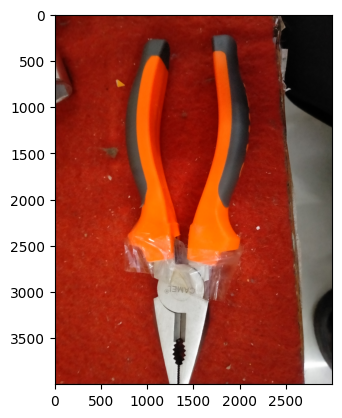

In [ ]:
image_rgb = cv2.cvtColor(gmbr1, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [ ]:
# Prepare image test

# img_test = cv2.imread('/content/drive/MyDrive/Skripsi/rumput laut/rumput laut/Rl___bulu_kucing/IMG-20230603-WA0173.jpg')
img3 = cv2.resize(gmbr1, default_image_size)
img3 = img_to_array(img3)
img3 = np.expand_dims(img3, axis=0)
img3 = img3/225

In [ ]:
img3.shape

(1, 256, 256, 3)

In [ ]:
y_pred = cs_adam_10.predict(img3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step


In [ ]:
y_pred

array([[0.]], dtype=float32)

In [ ]:
# for x, y in enumerate(y_pred):
#   positive = np.where(y_pred[x] == np.amax(y_pred[x]))
#   new = np.zeros(5, dtype=int)
#   new[positive] = 1
#   y_pred[x] = new

In [ ]:
with open('/content/forest_fire_smoke_transform.pkl', 'rb') as binarizer_file:
  binarizer = pickle.load(binarizer_file)

In [ ]:
y_invers = binarizer.inverse_transform(y_pred)

In [ ]:
y_invers


array(['gunting'], dtype='<U7')